# Redes neuronales convolucionales (CNN)

Los dataset <i>MNIST</i> y <i>Fashion MNIST</i> tienen las siguientes características:
<ul>
    <li>Tamaño de imágenes 28x28</li>
    <li>No tienen ruido, es decir, contenido específico </li>
    <li>Escala de grises</li>
</ul>

Desafortunadamente, las imágenes de un problema real no siempre cuentan con esas características, ya que pueden ser de color, de diferentes tamaños y contener información que no pertenece a la clase, entre otras.

En la presente actividad se resolverá un problema de clasificación binario mediante una CNN, cuyo *dataset* está compuesto de imágenes a color de perros y gatos.

## Cargar el dataset de perros y gatos

In [ ]:
#
#    Uso de google drive
#
from google.colab import drive
drive.mount('/content/drive/')
filename = '/tmp/cats_and_dogs.zip'

Mounted at /content/drive/


#### Descargar un .zip de 2.000 fotos JPG de gatos y perros, y extraerlo en /tmp (google drive).

In [ ]:
import urllib.request
url = ' https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# Local
#local_path = '/tmp/cats_and_dogs.zip'
#urllib.request.urlretrieve(url, local_path)

urllib.request.urlretrieve(url, filename)

('/tmp/cats_and_dogs.zip', <http.client.HTTPMessage at 0x79810a206b90>)

Utilizar la librería **os** para usar las funcionalidades dependientes del sistema operativo, y tener acceso al sistema de archivos. Además, emplear la librería **zipfile** para descomprimir los datos.

In [ ]:
import os
import zipfile

# Local
# zip_ref = zipfile.ZipFile(local_path, 'r')
# zip_ref.extractall('./')

local_zip = '/tmp/cats_and_dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')

zip_ref.close()

Definición de los directorios a utilizar para entrenar esta red neuronal

In [ ]:
#original
base_dir = '/tmp/cats_and_dogs_filtered'

# Local
#base_dir = './cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directorio para las imágenes de gatos para entrenamiento
train_cats_dir = os.path.join(train_dir, 'cats')

# Directorio para las imágenes de perros para entrenamiento
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directorio para las imagenes de perros y gatos para validación
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Nombres de los archivos en los directorios de entrenamiento de las imágenes de perros y gatos. Las convenciones de nombres de archivos son las mismas en el directorio de validación.

In [ ]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.581.jpg', 'cat.854.jpg', 'cat.349.jpg', 'cat.663.jpg', 'cat.626.jpg', 'cat.364.jpg', 'cat.406.jpg', 'cat.175.jpg', 'cat.393.jpg', 'cat.403.jpg']
['dog.779.jpg', 'dog.842.jpg', 'dog.178.jpg', 'dog.482.jpg', 'dog.967.jpg', 'dog.687.jpg', 'dog.418.jpg', 'dog.861.jpg', 'dog.176.jpg', 'dog.871.jpg']


Número total de imágenes de gatos y perros en los directorios de entrenamiento y validación:

## Visualización de las imágenes del dataset de perros y gatos

Para la visualización de las imágenes se va a emplear la librería **OpenCV** (*Open Source Computer Vision Library*), que se emplea en visión computacional, procesamiento de imágenes y *machine learning*. **OpenCV** es una librería *open-source*.

Los métodos que se van a ocupar para la visualización del dataset son:
<dd>
    <dl><b>imread</b> Carga una imagen de un archivo. En el caso de las imágenes a color, el orden de los canales es <b>BGR</b></dl>
    <dl><b>resize</b> Cambia el tamaño de una imagen</dl>
    <dl><b>cvtColor</b> Convierte la imagen de <b>BGR</b> a <b>RGB</b></dl>
    <dl><b>imshow</b> Visualiza una imagen</dl>
</dd>

Referencia: https://docs.opencv.org/3.4/index.html

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# Función para visualizar un conjunto de imágenes
# Se realiza un ajuste al tamaño para visualizarlas como van a entrar al modelo
def display_images_in_folder(folder_path):
    # Obtener todas las imagenes de la carpeta
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.jpg')]

    # Número de filas y columnas a desplegar
    num_images = len(files)
    num_cols = 2
    num_rows = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 7))
    axes = axes.ravel()

    for i, file in enumerate(files[:num_rows*num_cols]):
        img = cv2.imread(folder_path + '/' + file)
        # Redimensionar las imágenes a 150x150 pixeless
        img = cv2.resize(img, (150, 150))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Desplegar la imagen en la retícula
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(file)

In [ ]:
def display_images(set_img, num_img):
    fig, axes = plt.subplots(1, num_img, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(set_img, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
#Función para graficar resultados del performance del modelo
def PlotPerformance(acc, val_acc, loss, val_loss, name_exp):
    accuracy = acc
    val_accuracy = val_acc
    loss_model = loss
    val_loss_model = val_loss
    Accname = f'{name_exp} Accuracy'
    Lossname = f'{name_exp} Loss'

    epochs = range(len (accuracy))

    #------------------------------------------------
    # Accuracy
    #------------------------------------------------

    plt.plot(epochs, accuracy,'b',label='Training accuracy')
    plt.plot(epochs, val_accuracy,'r',label='Validation accuracy')
    plt.title(Accname)
    plt.legend()
    plt.figure()

    #------------------------------------------------
    # Loss
    #------------------------------------------------

    plt.plot(epochs, loss_model, 'b', label='Training Loss')
    plt.plot(epochs, val_loss_model, 'r', label='Validation Loss')
    plt.title(Lossname)
    plt.legend()
    plt.show()

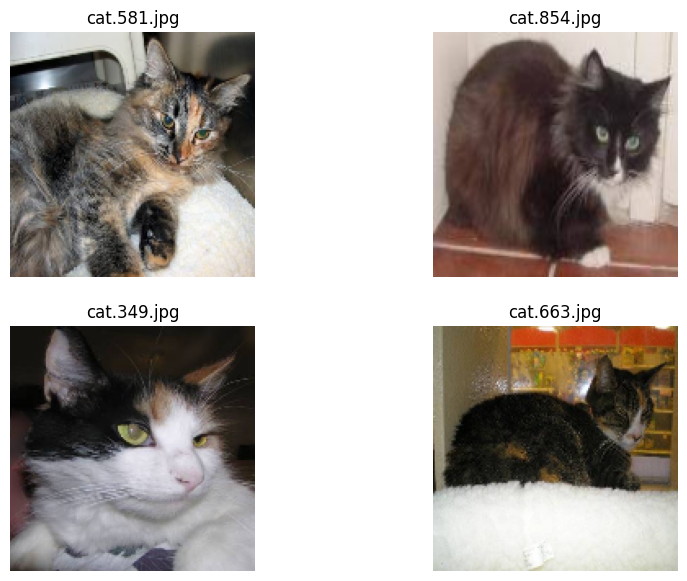

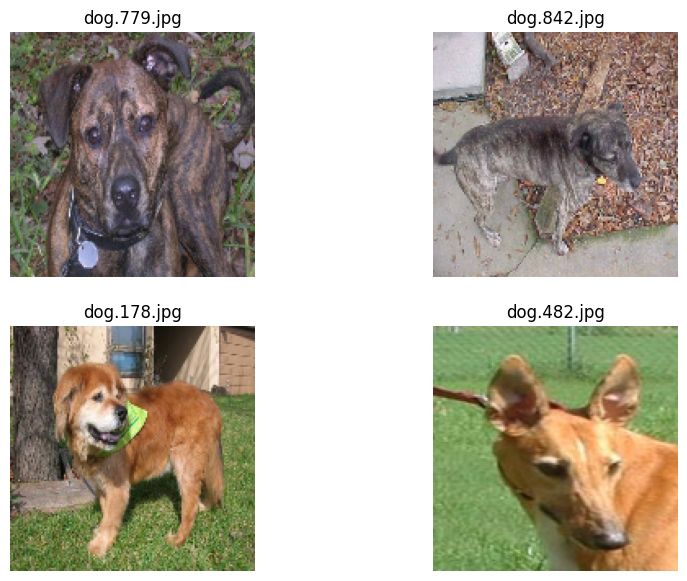

In [ ]:
display_images_in_folder(train_cats_dir)
display_images_in_folder(train_dogs_dir)

In [ ]:
print('Total de imagenes de entrenamiento de gatos\t:', len(os.listdir(train_cats_dir)))
print('Total de imagenes de entrenamiento de perros\t:', len(os.listdir(train_dogs_dir)))

print('Total de imagenes de validación de gatos\t:', len(os.listdir(validation_cats_dir)))
print('Total de imagenes de validación de perros\t:', len(os.listdir(validation_dogs_dir)))

Total de imagenes de entrenamiento de gatos	: 1000
Total de imagenes de entrenamiento de perros	: 1000
Total de imagenes de validación de gatos	: 500
Total de imagenes de validación de perros	: 500


# Preprocesamiento de imágenes

El preprocesamiento de las imágenes es un proceso donde se preparan las imágenes en crudo para posteriormente usarlas en el entrenamiento de un modelo.

Algunas de las técnicas de preprocesamiento de imágenes son:

<ul>
    <li>Normalización</li>
    <li>Redimensionar imágenes</li>
    <li>Reducción de ruido (<i>GaussianBlur</i> y <i>medianBlur</i>)</li>
    <li>Mejorar el contraste</li>
</ul>

El aplicar estás técnicas ayudan a mejorar la precisión de la CNN.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# NOTA: train_generator y validation_generator se emplean en los modelos de dropout y normalización

# Normalización
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flujo de imagenes de entrenamiento en batches de 20 usando el "train_datagen generator"
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))
# --------------------
# Flujo de imagenes de entrenamiento en batches de 20 usando el "test_datagen generator"
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Definición y entrenamiento de una CNN (convolutional neural network)

In [ ]:
import tensorflow as tf
print(tf.__version__)

tf.random.set_seed(42)

2.15.0


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.backend import clear_session

### Definición de una CNN

Las capas que se emplean en una CNN son:

<dd>
    <dl><b>Conv2D</b> Una capa convolucional emplea <i>kernels</i> para extraer los <i>features</i> más relevantes. Además, tienen la misma profundidad que una imagen. Los parámetros de esta capa son:</dl>
    <ul>
        <li><b>filters</b> Número entero que indica la dimensión de salida</li>
        <li><b>kernel_size</b> Tamaño del kernel, se puede dar un número entero o una tupla de dos números enteros.</li>
        <li><b>strides</b>= número entero o una tupla de dos números enteros. Indica el desplazamiento del filtro en la imagen.</li>
        <li><b>padding</b>= "same" evita la reducción de la dimensionalidad, "valid" significa no padding </li>
        <li><b>input_shape</b>= Tupla que indica el tamaño de las imágenes. Sólo se usa en la primera capa del modelo</li>
        <li><b>activation</b>= Función de activación </li>
    </ul>
    <dl><b>MaxPooling2D</b> Reduce la imagen de entrada en lo ancho y largo, calculando el valor máximo de la ventana. Lo anterior se lleva a cabo en cada canal de la entrada. Se debe especificar el tamaño de la ventana, ya sea mediante un número entero o una tupla de enteros.</dl>
</dd>

In [ ]:
model = Sequential([
    # La entrada es una imagen de 150x150 pixeles en tres canales R,G,B
    Conv2D(32, 3, activation='relu', input_shape= (150, 150, 3)),
    MaxPooling2D(2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Aplanar la salida de las capas convolucionales
    Flatten(),
    # Capa oculta de 512 Neuronas
    Dense(512, activation='relu'),
    # Salida binaria. Se obtienen valores 0-1, donde 0 son gatos ('cats') y 1 son perros ('dogs')
    Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

### Compilar el modelo

In [ ]:
model.compile(optimizer=RMSprop(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy'])

### Entrenamiento del modelo

Parámetro *validation_steps* se calcula dividiendo el número de muestras del conjunto de validación entre el batch size. En este caso es 1000/20, 50.<br>
Parámetro *steps_per_epoch* se calcula dividiendo el número de muestras del conjunto de entrenamiento entre el batch size. En este caso 2000/20 = 100.<br>
Parámetro *epochs* es el número de iteraciones que se va a entrenar el modelo.

In [ ]:
# tu código para la variable history que guarda el entrenamiento de la CNN del ejercicio 3 aquí
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=100,
                    epochs=15,
                    validation_steps=50,
                    verbose=2)

Epoch 1/15
100/100 - 11s - loss: 0.7118 - accuracy: 0.4960 - val_loss: 0.6930 - val_accuracy: 0.5000 - 11s/epoch - 107ms/step
Epoch 2/15
100/100 - 5s - loss: 0.6931 - accuracy: 0.5355 - val_loss: 0.6879 - val_accuracy: 0.5030 - 5s/epoch - 54ms/step
Epoch 3/15
100/100 - 5s - loss: 0.6740 - accuracy: 0.5985 - val_loss: 0.6334 - val_accuracy: 0.6680 - 5s/epoch - 46ms/step
Epoch 4/15
100/100 - 6s - loss: 0.6389 - accuracy: 0.6450 - val_loss: 0.6165 - val_accuracy: 0.6690 - 6s/epoch - 59ms/step
Epoch 5/15
100/100 - 5s - loss: 0.5883 - accuracy: 0.6870 - val_loss: 0.5592 - val_accuracy: 0.7230 - 5s/epoch - 47ms/step
Epoch 6/15
100/100 - 5s - loss: 0.5564 - accuracy: 0.7260 - val_loss: 0.6135 - val_accuracy: 0.6660 - 5s/epoch - 46ms/step
Epoch 7/15
100/100 - 7s - loss: 0.5214 - accuracy: 0.7390 - val_loss: 0.6553 - val_accuracy: 0.6770 - 7s/epoch - 72ms/step
Epoch 8/15
100/100 - 5s - loss: 0.4539 - accuracy: 0.7865 - val_loss: 0.6664 - val_accuracy: 0.6700 - 5s/epoch - 46ms/step
Epoch 9/15
10

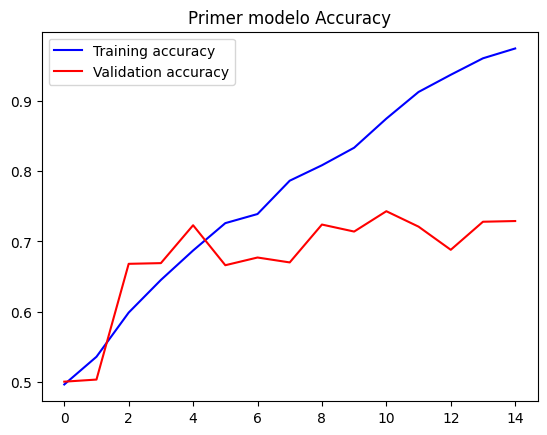

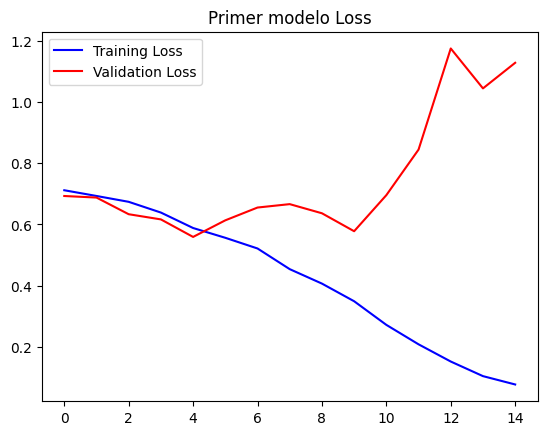

In [ ]:
PlotPerformance(history.history['accuracy'],
                history.history['val_accuracy'],
                history.history['loss'],
                history.history['val_loss'],
                'Primer modelo')

#### Como se puede observar, el modelo reduce su *loss* (error) con los datos en entrenamiento pero en los datos de validación aumenta. Lo anterior indica que el modelo no va a tener un buen desempeño con datos no vistos (nuevos). A este comportamiento se le conoce como **overfitting** o sobreajuste.

<h1>Overfitting</h1>

El *overfitting*, también conocido como **sobreajuste**, se presenta cuando la red neuronal tiene un buen desempeño en el conjunto de entrenamiento pero con datos nuevos, las inferencias son imprecisas, esto es, no tiene capacidad de generalizar.

Las causas del sobreajuste pueden ser:
* El conjunto de entrenamiento es pequeño y no tiene suficiente información para que el modelo aprenda
* El conjunto de entrenamiento contiene información irrelevante
* El número de épocas es muy grande
* La complejidad del modelo es superior al conjunto de datos.

El *overfitting* se puede prevenir con:
* Early stopping
* Regularización
* Data augmentation
* Capa Dropout

Para este problema de clasificación, las gráficas de *loss* y *accuracy* deben ser similares a:

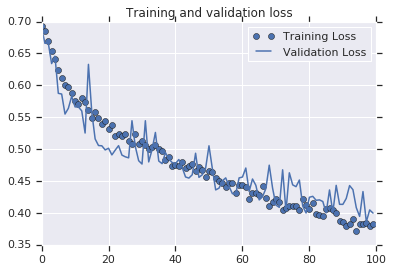
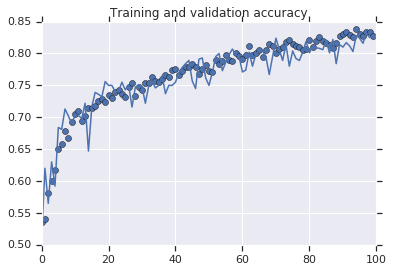

## DataAugmentation

In [ ]:
#Definición del modelo
model1 = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape= (150, 150, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

#Compilación
model1.compile(optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics = ['accuracy'])

In [ ]:
# Preprocesamiento de imágenes
train_dgen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_dgen = ImageDataGenerator(
    rescale=1./255
)

train_gen = train_dgen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode= 'binary',
                                                    target_size= (150, 150))

validation_gen = test_dgen.flow_from_directory(validation_dir,
                                                        batch_size=20,
                                                        class_mode = 'binary',
                                                        target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


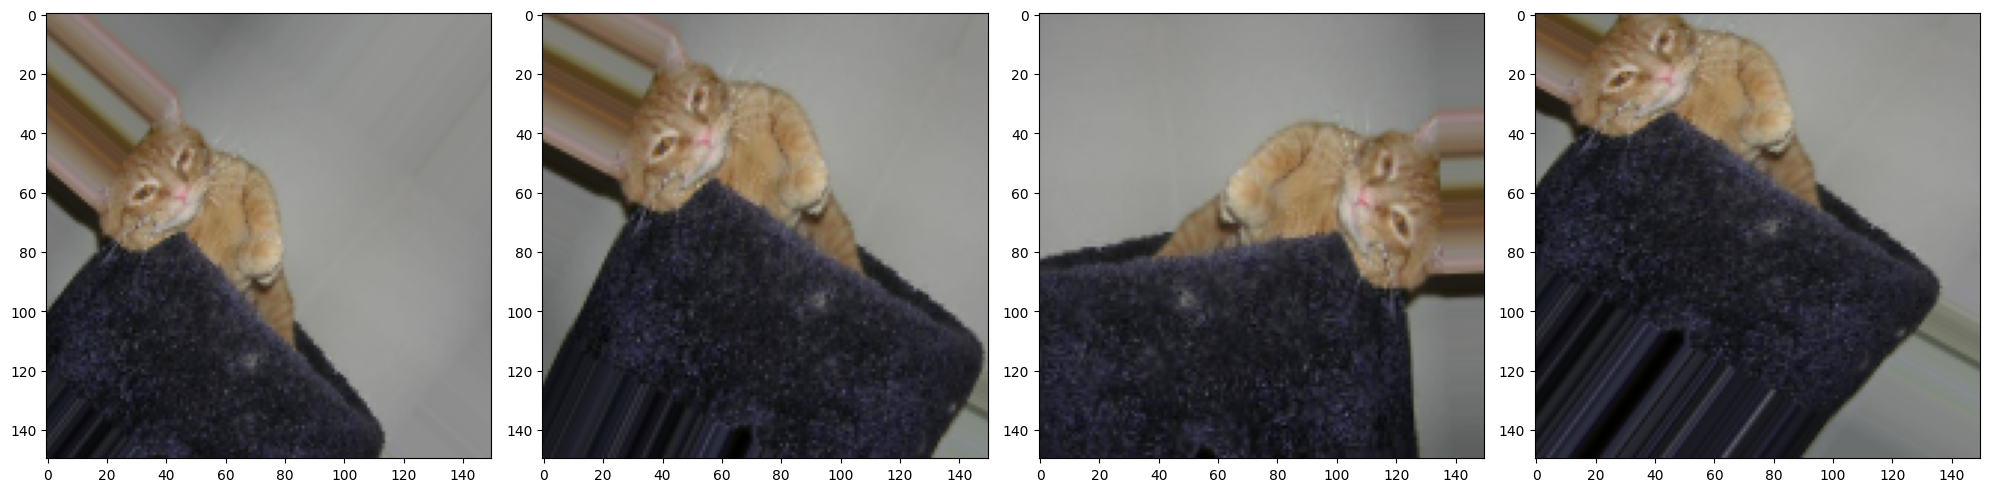

In [ ]:
number_img = 4
augmented_images = [train_gen[0][0][0] for i in range(number_img)]
display_images(augmented_images, number_img)

In [ ]:
#Entrenamiento
history1 = model1.fit(train_gen,
                    validation_data=validation_gen,
                    steps_per_epoch=100,
                    epochs=20,
                    validation_steps=50,
                    verbose=2)

Epoch 1/20
100/100 - 18s - loss: 0.6961 - accuracy: 0.5275 - val_loss: 0.6713 - val_accuracy: 0.5630 - 18s/epoch - 184ms/step
Epoch 2/20
100/100 - 15s - loss: 0.6798 - accuracy: 0.5710 - val_loss: 0.6638 - val_accuracy: 0.6180 - 15s/epoch - 148ms/step
Epoch 3/20
100/100 - 15s - loss: 0.6631 - accuracy: 0.5855 - val_loss: 0.6306 - val_accuracy: 0.6550 - 15s/epoch - 147ms/step
Epoch 4/20
100/100 - 15s - loss: 0.6484 - accuracy: 0.6135 - val_loss: 0.6094 - val_accuracy: 0.6810 - 15s/epoch - 147ms/step
Epoch 5/20
100/100 - 15s - loss: 0.6310 - accuracy: 0.6430 - val_loss: 0.6043 - val_accuracy: 0.6590 - 15s/epoch - 150ms/step
Epoch 6/20
100/100 - 15s - loss: 0.6208 - accuracy: 0.6425 - val_loss: 0.5864 - val_accuracy: 0.6780 - 15s/epoch - 153ms/step
Epoch 7/20
100/100 - 17s - loss: 0.6128 - accuracy: 0.6645 - val_loss: 0.6381 - val_accuracy: 0.6160 - 17s/epoch - 166ms/step
Epoch 8/20
100/100 - 15s - loss: 0.5974 - accuracy: 0.6865 - val_loss: 0.6301 - val_accuracy: 0.6180 - 15s/epoch - 147

## Capa Dropout

La capa *dropout* desactiva un porcentaje de neuronas en una capa de una red neuronal, las cuales no se toman en cuenta en el proceso de *backpropagation* del entrenamiento de la red.

La explicación de como funciona la capa dropout durante el entrenamiento e inferencias se encuentra en https://towardsdatascience.com/dropout-in-neural-networks-47a162d621d9


In [ ]:
# del model2
# clear_session()
# tf.compat.v1.reset_default_graph()

In [ ]:
# Definición del modelo
model2 = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape= (150, 150, 3)),
    MaxPooling2D(2,2),
    Dropout(0.6),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.6),
    Dense(512, activation='relu'),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

#Compilación
model2.compile(optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics = ['accuracy'])

In [ ]:
#Entrenamiento
history2 = model2.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=100,
                    epochs=20,
                    validation_steps=50,
                    verbose=2)

Epoch 1/20
100/100 - 10s - loss: 0.7881 - accuracy: 0.4985 - val_loss: 0.6918 - val_accuracy: 0.5010 - 10s/epoch - 101ms/step
Epoch 2/20
100/100 - 5s - loss: 0.7090 - accuracy: 0.4960 - val_loss: 0.6933 - val_accuracy: 0.4990 - 5s/epoch - 47ms/step
Epoch 3/20
100/100 - 6s - loss: 0.6971 - accuracy: 0.5065 - val_loss: 0.6923 - val_accuracy: 0.5750 - 6s/epoch - 57ms/step
Epoch 4/20
100/100 - 5s - loss: 0.6893 - accuracy: 0.5380 - val_loss: 0.6923 - val_accuracy: 0.5480 - 5s/epoch - 45ms/step
Epoch 5/20
100/100 - 5s - loss: 0.6865 - accuracy: 0.5445 - val_loss: 0.6908 - val_accuracy: 0.5720 - 5s/epoch - 53ms/step
Epoch 6/20
100/100 - 5s - loss: 0.6867 - accuracy: 0.5440 - val_loss: 0.6896 - val_accuracy: 0.5770 - 5s/epoch - 52ms/step
Epoch 7/20
100/100 - 6s - loss: 0.6789 - accuracy: 0.5640 - val_loss: 0.6911 - val_accuracy: 0.5550 - 6s/epoch - 58ms/step
Epoch 8/20
100/100 - 5s - loss: 0.6725 - accuracy: 0.5840 - val_loss: 0.6875 - val_accuracy: 0.5910 - 5s/epoch - 45ms/step
Epoch 9/20
10

## Regularización

La regularización es un método que penaliza la función de pérdida (*loss*) durante el entrenamiento de un modelo. Los tipos de regularización son:
<ol>
    <li>L1 (<i>Regresión Lasso</i>) Suma el valor absoluto de los coeficientes como penalización</li>
    <li>L2 (<i>Regresión Ridge</i>) Suma el cuadrado de los coeficientes como penalización</li>
    <li>L1L2 (<i>Regresión Elastic Net</i>) Suma el cuadrado de los coeficientes como penalización</li>
</ol>
    


In [ ]:
# Definición del modelo
model3 = Sequential(
[
    Conv2D(16, (3,3), activation='relu', input_shape= (150, 150, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.L2(0.5)),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
]
)

#Compilación
model3.compile(optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy']
    )

In [ ]:
#Entrenamiento
history3 = model3.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=100,
                    epochs=20,
                    validation_steps=50,
                    verbose=2)

Epoch 1/20
100/100 - 6s - loss: 6.0991 - accuracy: 0.5415 - val_loss: 0.8459 - val_accuracy: 0.5600 - 6s/epoch - 62ms/step
Epoch 2/20
100/100 - 6s - loss: 0.7067 - accuracy: 0.5925 - val_loss: 0.6547 - val_accuracy: 0.6190 - 6s/epoch - 59ms/step
Epoch 3/20
100/100 - 7s - loss: 0.6555 - accuracy: 0.6240 - val_loss: 0.6321 - val_accuracy: 0.6600 - 7s/epoch - 67ms/step
Epoch 4/20
100/100 - 5s - loss: 0.6275 - accuracy: 0.6740 - val_loss: 0.6403 - val_accuracy: 0.6470 - 5s/epoch - 45ms/step
Epoch 5/20
100/100 - 5s - loss: 0.6000 - accuracy: 0.6985 - val_loss: 0.6200 - val_accuracy: 0.6600 - 5s/epoch - 51ms/step
Epoch 6/20
100/100 - 5s - loss: 0.6062 - accuracy: 0.6820 - val_loss: 0.6030 - val_accuracy: 0.6950 - 5s/epoch - 53ms/step
Epoch 7/20
100/100 - 5s - loss: 0.5850 - accuracy: 0.7145 - val_loss: 0.6019 - val_accuracy: 0.6990 - 5s/epoch - 45ms/step
Epoch 8/20
100/100 - 5s - loss: 0.5463 - accuracy: 0.7420 - val_loss: 0.6212 - val_accuracy: 0.6930 - 5s/epoch - 54ms/step
Epoch 9/20
100/1

# Data Augmentation, Dropout y EarlyStopping

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
]

In [ ]:
#Definición del modelo
model4 = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape= (150, 150, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

#Compilación
model4.compile(optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics = ['accuracy'])

In [ ]:
#Entrenamiento
history4 = model4.fit(train_gen,
                    validation_data=validation_gen,
                    steps_per_epoch=100,
                    epochs=50,
                    validation_steps=50,
                    verbose=2,
                    callbacks = my_callbacks)

Epoch 1/50
100/100 - 16s - loss: 0.6991 - accuracy: 0.5075 - val_loss: 0.6838 - val_accuracy: 0.5030 - 16s/epoch - 164ms/step
Epoch 2/50
100/100 - 15s - loss: 0.6868 - accuracy: 0.5440 - val_loss: 0.6626 - val_accuracy: 0.6250 - 15s/epoch - 148ms/step
Epoch 3/50
100/100 - 15s - loss: 0.6647 - accuracy: 0.5925 - val_loss: 0.6300 - val_accuracy: 0.6560 - 15s/epoch - 149ms/step
Epoch 4/50
100/100 - 15s - loss: 0.6461 - accuracy: 0.6275 - val_loss: 0.6040 - val_accuracy: 0.6800 - 15s/epoch - 149ms/step
Epoch 5/50
100/100 - 15s - loss: 0.6291 - accuracy: 0.6500 - val_loss: 0.6359 - val_accuracy: 0.6060 - 15s/epoch - 149ms/step
Epoch 6/50
100/100 - 15s - loss: 0.6231 - accuracy: 0.6605 - val_loss: 0.5891 - val_accuracy: 0.7040 - 15s/epoch - 154ms/step
Epoch 7/50
100/100 - 15s - loss: 0.6218 - accuracy: 0.6520 - val_loss: 0.5819 - val_accuracy: 0.7060 - 15s/epoch - 150ms/step
Epoch 8/50
100/100 - 17s - loss: 0.6004 - accuracy: 0.6795 - val_loss: 0.6059 - val_accuracy: 0.6420 - 17s/epoch - 166

### Gráficas de los modelos entrenados

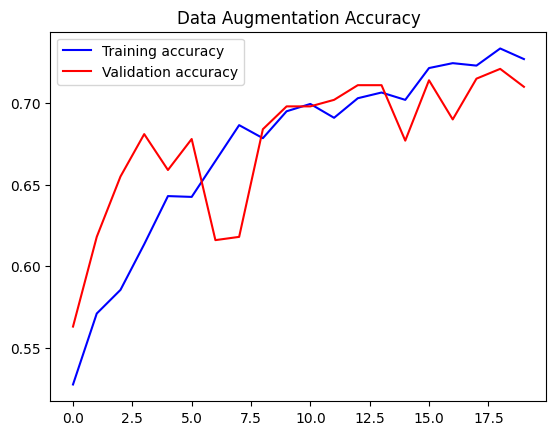

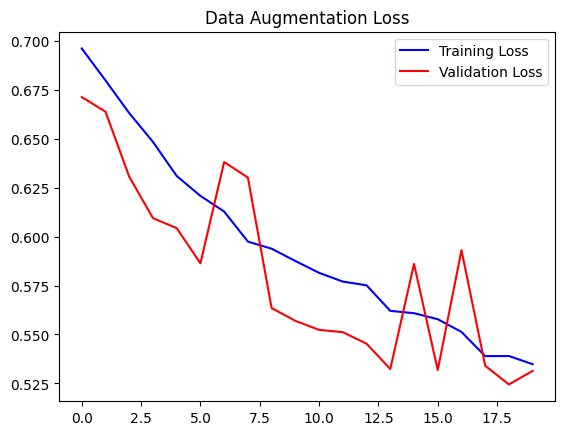

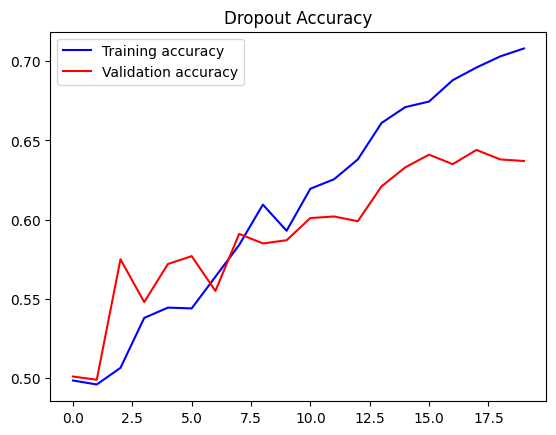

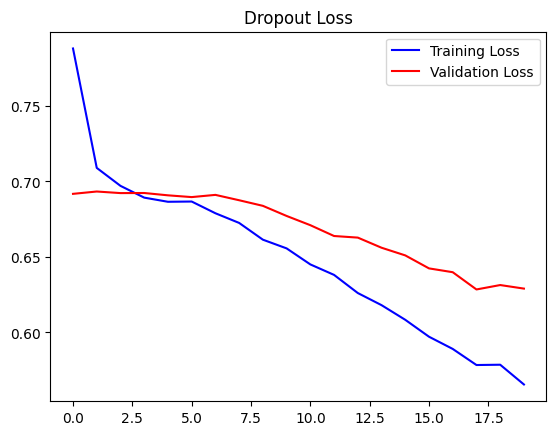

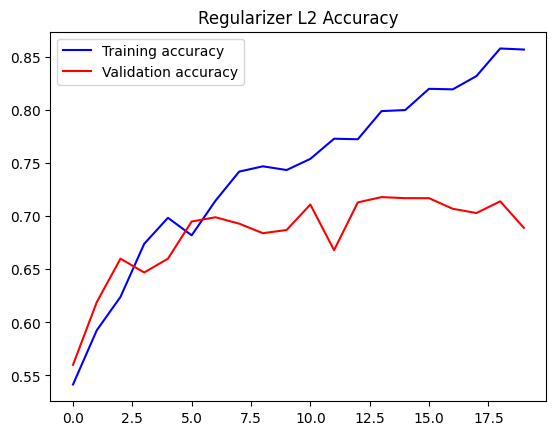

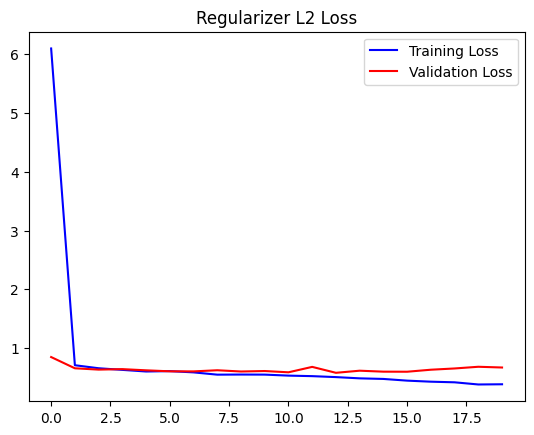

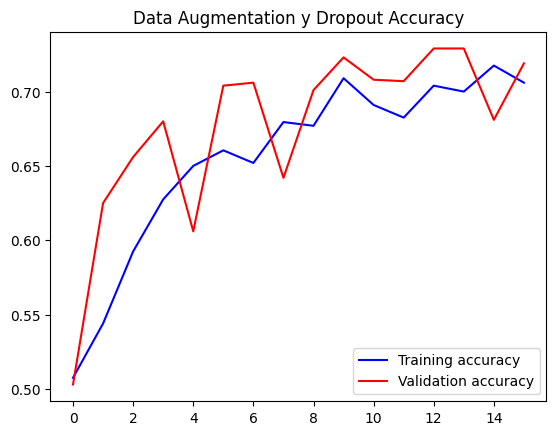

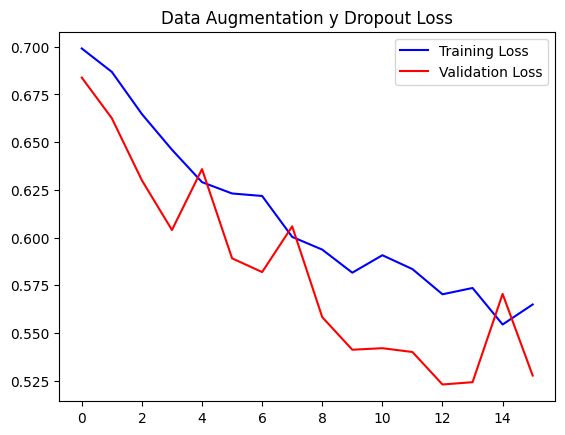

In [ ]:
PlotPerformance(
    history1.history ['accuracy'],
    history1.history['val_accuracy'],
    history1.history['loss'],
    history1.history['val_loss'],
    'Data Augmentation'
)

PlotPerformance(
    history2.history ['accuracy'],
    history2.history['val_accuracy'],
    history2.history['loss'],
    history2.history['val_loss'],
    'Dropout'
)

PlotPerformance(
    history3.history ['accuracy'],
    history3.history['val_accuracy'],
    history3.history['loss'],
    history3.history['val_loss'],
    'Regularizer L2'
)

PlotPerformance(
    history4.history ['accuracy'],
    history4.history['val_accuracy'],
    history4.history['loss'],
    history4.history['val_loss'],
    'Data Augmentation y Dropout'
)

# Inferencias con nuevos datos

In [ ]:
import numpy as np
import keras.utils as utils_img

In [ ]:
def print_clase(prob):
    if prob>0.5:
        print(f'Es un perro - {prob[0]}')
    else:
        print(f'Es un gato - {prob[0]}')

def preprocess(raw_img):
    img = utils_img.img_to_array(raw_img)
    # Normalización
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    img_out = np.vstack([img])

    return img_out

In [ ]:
# Local
'''
while(True):
    path = "./"
    file_name = input()

    if len(file_name)==0:
        break

    path_file = path+file_name
    raw_img = utils_img.load_img(path_file, target_size=(150, 150))

    img = preprocess(raw_img)
    classes = model2.predict(img, batch_size=10, verbose=0)

    print(path_file)
    print_clase(classes)
'''

In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  raw_img = utils_img.load_img(path, target_size=(150, 150))
  img = preprocess(raw_img)
  classes = model4.predict(img, batch_size=10)
  print(fn)
  print_clase(classes)

Saving test3.jpeg to test3 (1).jpeg
1/1 [==============================] - 0s 211ms/step
test3 (1).jpeg
Es un gato - [0.18422085]
